## Data Scientist Project - Writing a Data Scientist Blog Post

The code below aims to answer 3 questions based on the 2017 Stack Overflow survey dataset:

1. How well can we predict an individual's career satisfaction?  What aspects correlate well to career satisfaction?
2. How does working remotely correlate with job and career satisfaction, and is there a correlation with salary?
3. Does the pronunciation of "GIF" differ between people who believe there is a right way and a wrong way to do everything and those who do not?

### Initial Setup

Firstly we import the required modules and read the data from the CSV file into a dataframe.  Warnings are turned off to minimise unnecessary output relating to deprecated functions.

#### Steps of Data Science Process completed (for all 3 questions):

**Gather** - the data has been gathered and loaded into a dataframe

**Assess** - We review the first few rows of the dataset 


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
import warnings

warnings.filterwarnings('ignore')

%matplotlib inline

df = pd.read_csv('./survey_results_public.csv')
df.head()

,Respondent,Professional,ProgramHobby,Country,University,EmploymentStatus,FormalEducation,MajorUndergrad,HomeRemote,CompanySize,...,StackOverflowMakeMoney,Gender,HighestEducationParents,Race,SurveyLong,QuestionsInteresting,QuestionsConfusing,InterestedAnswers,Salary,ExpectedSalary
0,1,Student,"Yes, both",United States,No,"Not employed, and not looking for work",Secondary school,NaN,NaN,NaN,...,Strongly disagree,Male,High school,White or of European descent,Strongly disagree,Strongly agree,Disagree,Strongly agree,NaN,NaN
1,2,Student,"Yes, both",United Kingdom,"Yes, full-time",Employed part-time,Some college/university study without earning ...,Computer science or software engineering,"More than half, but not all, the time",20 to 99 employees,...,Strongly disagree,Male,A master's degree,White or of European descent,Somewhat agree,Somewhat agree,Disagree,Strongly agree,NaN,37500.0
2,3,Professional developer,"Yes, both",United Kingdom,No,Employed full-time,Bachelor's degree,Computer science or software engineering,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A professional degree,White or of European descent,Somewhat agree,Agree,Disagree,Agree,113750.0,NaN
3,4,Professional non-developer who sometimes write...,"Yes, both",United States,No,Employed full-time,Doctoral degree,A non-computer-focused engineering discipline,"Less than half the time, but at least one day ...","10,000 or more employees",...,Disagree,Male,A doctoral degree,White or of European descent,Agree,Agree,Somewhat agree,Strongly agree,NaN,NaN
4,5,Professional developer,"Yes, I program as a hobby",Switzerland,No,Employed full-time,Master's degree,Computer science or software engineering,Never,10 to 19 employees,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Three functions are created for use in question 1.  These are:

clean_data:
Receives the survey results dataframe and removes rows with no value entered for career satifaction as this is the response we are looking to model.  
It then creates a vector containing only the CareerSatisfaction data and a dataframe containing the survey results excluding CareerSatisfaction, Respondent (a unique identifier) and ExpectedSalary (a low quality data column where over 95% of responses are NA).
NA values in numeric columns are filled with the mean value for that column.  Categorical columns are replaced with dummy columns containing 0 or 1 for each possible answer.
The vector and cleaned dataframe are returned from this function.

find_optimal_lm_mod:
This function receives the dataframe and vector produced by the clean_data function along with a series of cutoff values that are used to determine which dummy categorical values to use.  If the number of positive responses in the column is less than the cutoff value, the column is excluded.
For each cutoff value provided, it is applied to the dataframe and output is split into a training set and a test set, as is the vector.  The test size and random state are initialised when the function is run. The linear regression model is then fitted and the predicted response is calculated.  The resulting r squared values are collated in lists
Once all cutoff values have been run a plot is drawn of the resulting lists and the best cutoff value is determined.
The test is run again on this best value and the result is returned from the function.

coef_weights:
This function takes each column from the training dataframe and appends its correlation coefficient as calculated in the find_optimal_lm_mod function, as well as the absolute coefficient.  This is then sorted by the absolute coefficient value to show the most influential coefficients at the top of the list.


In [2]:
def clean_data(df, response):
    '''
    INPUT
    df - pandas dataframe 
    response - the column of the dataframe that we wish to predict
    
    OUTPUT
    X - A dataframe holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no career satisfaction values
    2. Create dataframe X as all the columns that are not the CareerSatisfaction column
    3. Create vector y as the CareerSatisfaction column
    4. Drop the CareerSatisfaction, Respondent, and the ExpectedSalary columns from X
    5. For each numeric variable in X, fill the column with the mean value of the column.
    6. Create dummy columns for all the categorical variables in X, drop the original columns
    '''
    # Drop rows with missing Career Satisfaction values
    df = df.dropna(subset=[response], axis=0)
    y = df[response]
    
    #Drop respondent and expected salary columns along with the response being considered
    df = df.drop([response, 'Respondent', 'ExpectedSalary'], axis=1)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
        
    # Dummy the categorical variables
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        # for each cat add dummy var, drop original column
        df = pd.concat([df.drop(var, axis=1), pd.get_dummies(df[var], prefix=var, prefix_sep='_', drop_first=True)], axis=1)
    
    X = df
    return X, y


def find_optimal_lm_mod(X, y, cutoffs, test_size = .30, random_state=42, plot=True):
    '''
    INPUT
    X - pandas dataframe, X matrix
    y - pandas dataframe, response variable
    cutoffs - list of ints, cutoff for number of non-zero values in dummy categorical vars
    test_size - float between 0 and 1, default 0.3, determines the proportion of data as test data
    random_state - int, default 42, controls random state for train_test_split
    plot - boolean, default 0.3, True to plot result

    OUTPUT
    r2_scores_test - list of floats of r2 scores on the test data
    r2_scores_train - list of floats of r2 scores on the train data
    lm_model - model object from sklearn
    X_train, X_test, y_train, y_test - output from sklearn train test split used for optimal model
    '''
    r2_scores_test, r2_scores_train, num_feats, results = [], [], [], dict()
    for cutoff in cutoffs:

        #reduce X matrix
        reduce_X = X.iloc[:, np.where((X.sum() > cutoff) == True)[0]]
        num_feats.append(reduce_X.shape[1])

        #split the data into train and test
        X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

        #fit the model and obtain pred response
        lm_model = LinearRegression(normalize=True)
        lm_model.fit(X_train, y_train)
        y_test_preds = lm_model.predict(X_test)
        y_train_preds = lm_model.predict(X_train)

        #append the r2 value from the test set
        r2_scores_test.append(r2_score(y_test, y_test_preds))
        r2_scores_train.append(r2_score(y_train, y_train_preds))
        results[str(cutoff)] = r2_score(y_test, y_test_preds)

    if plot:
        plt.plot(num_feats, r2_scores_test, label="Test", alpha=.5)
        plt.plot(num_feats, r2_scores_train, label="Train", alpha=.5)
        plt.xlabel('Number of Features')
        plt.ylabel('Rsquared')
        plt.title('Rsquared by Number of Features')
        plt.legend(loc=1)
        plt.show()

    best_cutoff = max(results, key=results.get)

    #reduce X matrix
    reduce_X = X.iloc[:, np.where((X.sum() > int(best_cutoff)) == True)[0]]
    num_feats.append(reduce_X.shape[1])

    #split the data into train and test
    X_train, X_test, y_train, y_test = train_test_split(reduce_X, y, test_size = test_size, random_state=random_state)

    #fit the model
    lm_model = LinearRegression(normalize=True)
    lm_model.fit(X_train, y_train)

    return r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test


def coef_weights(coefficients, X_train):
    '''
    INPUT:
    coefficients - the coefficients of the linear model 
    X_train - the training data, so the column names can be used
    OUTPUT:
    coefs_df - a dataframe holding the coefficient, estimate, and abs(estimate)
    
    Provides a dataframe that can be used to understand the most influential coefficients
    in a linear model by providing the coefficient estimates along with the name of the 
    variable attached to the coefficient.
    '''
    coefs_df = pd.DataFrame()
    coefs_df['est_int'] = X_train.columns
    coefs_df['coefs'] = lm_model.coef_
    coefs_df['abs_coefs'] = np.abs(lm_model.coef_)
    coefs_df = coefs_df.sort_values('abs_coefs', ascending=False)
    return coefs_df

### Question 1: How well can we predict an individual's Career Satisfaction?  What aspects correlate well to career satisfaction?

Firstly we clean the data to replace categorical data with dummy columns, and replace empty numeric cells with the mean value for their column.

#### Steps of Data Science Process completed:

**Clean** - the data has now been cleaned and is ready for analysis

In [3]:
#Use the clean_data function to create X and y
X, y = clean_data(df, 'CareerSatisfaction')  

We now begin the analysis of the data, setting appropriate cutoff calues and applying the function to find the optimal linear model.

#### Steps of Data Science Process completed:

**Analyse** - we analyse the data using the find_optimal_lm_mod function

**Model** - the function determines the best model to use.  We then print the values associated with the model (number of columns and r-squared values for testing and training the model)

**Visualise** - a chart is plotted showing the results of the function

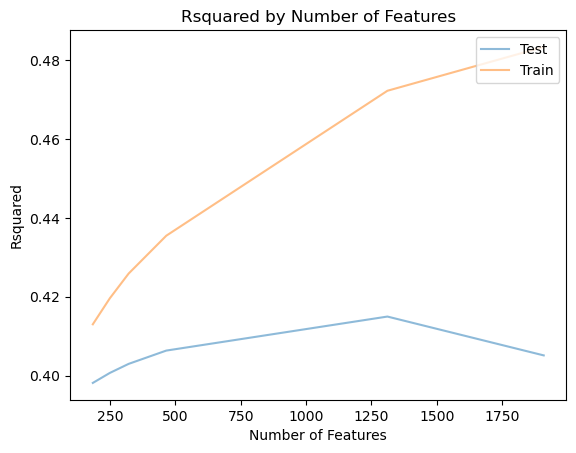

In [4]:
cutoffs = [5000, 3500, 2500, 1000, 100, 50]

#Use the find_optimal_lm_mod function to create r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train and y_test 
r2_scores_test, r2_scores_train, lm_model, X_train, X_test, y_train, y_test = find_optimal_lm_mod(X, y, cutoffs)

In [5]:
print(X_train.shape[1]) #Number of columns
print(r2_scores_test[np.argmax(r2_scores_test)]) # The model we should implement test_r2
print(r2_scores_train[np.argmax(r2_scores_test)]) # The model we should implement train_r2

1311
0.41498321003589556
0.4722363269300336


The coef_weights function is then used to find the correlation coefficient of each variable

#### Steps of Data Science Process completed:

**Visualise** - a table is produced showing the top 10 coeffients

In [6]:
#Use the function coef_weights to create a dataframe holding the correlation coefficient, estimate, and abs(estimate) 
coef_df = coef_weights(lm_model.coef_, X_train)

#View the highest correlations
coef_df.head(10)

,est_int,coefs,abs_coefs
69,"EmploymentStatus_Not employed, but looking for...",-1.825364,1.825364
220,ExCoder10Years_Strongly disagree,-1.536963,1.536963
4,Professional_Professional developer,0.934227,0.934227
37,Country_Mexico,0.905089,0.905089
468,Currency_Mexican pesos (MXN$),-0.645487,0.645487
58,Country_Turkey,-0.559272,0.559272
66,EmploymentStatus_I prefer not to say,-0.553890,0.553890
218,ExCoder10Years_Disagree,-0.529222,0.529222
5,Professional_Professional non-developer who so...,0.523690,0.523690
0,JobSatisfaction,0.514423,0.514423


From this analysis it would appear that we are not able to predict career satisfaction particularly well, with an r squared value of only 0.41 on the test model when the optimum number of 1311 columns is used.

Of the factors that have the most influence on career satisfaction, being unemployed has the largest negative and absolute correlation coefficient.  Negative responses by ex-coders to the question "My career is going the way I thought it would 10 years ago" also have some of the largest negative coefficients.  This would be expected as these all have negative connotations for the respondents career.  Respondents who wouldn't say what their employment status was also had a negative correlation which may suggest that their reticence to respond reflects a less satisfactory employment status.

Perhaps unsurprisingly job satisfaction has a positive correlation coefficient as respondents that are happy in their job are more likely to be happy in their career and vice versa.

Working in Turkey appears to have a negative relationship with career satisfaction, whereas working in Mexico appears to have a relatively strong positive relationship.  Interestingly being paid in Mexican pesos appears to have a negative relationship.  The reason for that apparent contradiction would merit further investigation, from looking at the dataset it would appear around half of Mexico based respondents did not complete the currency question.

Finally those who responded to the question relating to their profession as "Professional developer" or "Professional non-developer who sometimes writes code" had a positive correlation with career satisfaction.  The only other responses to this question were "Student", "Used to be a professional developer" or "Other" so this would be consistent with respondents in professional coding jobs being happier with their careers.

Whilst the model will not do a great job in predicting career satisfaction, we have been able to draw some interesting conclusions from the results.

### Question 2: How does working remotely correlate with job and career satisfaction, and is there a correlation with salary?

Firstly we reduce the dataset to only the 4 columns we require (HomeRemote, JobSatisfaction, CareerSatisfaction, Salary)
Then we rename them to make them more readable for the end user.
Then we group the values by HomeRemote, obtaining the mean for each of the 3 other columns

#### Steps of Data Science Process completed:

**Clean** - unnecessary data has been removed and the remaining columns have been tidied up.  The remote working categories are reordered to put them in the correct order.

**Analyse** - the data has been grouped to provide 3 mean values for each remote working category.

**Model** - no model is required for this question

**Visualise** - a table is output with a colour gradient to help the end user see the detail of the results.

In [7]:
# Drop all columns except those of interest, namely:
#    HomeRemote - How often the respondent works remotely 
#    JobSatisfaction - The respondents job satisfaction on a scale of 1-10
#    CareerSatisfaction - The respondents career satisfaction on a scale of 1-10 
#    Salary - The reported salary of the respondent
remote_working_df = df[['HomeRemote','JobSatisfaction','CareerSatisfaction', 'Salary']]

# Rename column headers to be more user friendly
remote_working_df.rename(columns={'HomeRemote': 'Time spent working remotely'
                                 , 'JobSatisfaction':'Job Satisfaction'
                                 , 'CareerSatisfaction':'Career Satisfaction'}, inplace=True)

# Group the results by the HomeRemote response to get the mean values of the other 3 columns
remote_working_df = remote_working_df.groupby(['Time spent working remotely']).mean()

# Order the results by how often the resondent works remotely, from most often to least often
# It has been assumed that "It's Complicated" is not Never so has been placed higher in the order
remote_sorter = ["All or almost all the time (I'm full-time remote)"
                , "More than half, but not all, the time"
                , "About half the time"
                , "Less than half the time, but at least one day each week"
                , "A few days each month"
                , "It's complicated"
                , "Never"]
remote_working_df = remote_working_df.reindex(remote_sorter,axis='index')

remote_working_df.head(10)

,Job Satisfaction,Career Satisfaction,Salary
Time spent working remotely,,,
All or almost all the time (I'm full-time remote),7.388430,7.645147,74287.848573
"More than half, but not all, the time",6.953184,7.377029,53829.468074
About half the time,6.973702,7.467611,56568.194664
"Less than half the time, but at least one day each week",7.120125,7.595121,64508.428807
A few days each month,7.077509,7.477806,59226.876756
It's complicated,6.840830,7.289413,55742.095768
Never,6.632502,7.074931,46862.620192


In [8]:
# create a colour gradient in each column to indicate more clearly the high and low values, with high values being darker green
cm = sns.light_palette("seagreen", as_cmap=True)

remote_working_df.style.background_gradient(cmap=cm)

,Job Satisfaction,Career Satisfaction,Salary
Time spent working remotely,,,
All or almost all the time (I'm full-time remote),7.388430,7.645147,74287.848573
"More than half, but not all, the time",6.953184,7.377029,53829.468074
About half the time,6.973702,7.467611,56568.194664
"Less than half the time, but at least one day each week",7.120125,7.595121,64508.428807
A few days each month,7.077509,7.477806,59226.876756
It's complicated,6.840830,7.289413,55742.095768
Never,6.632502,7.074931,46862.620192


From this analysis it would appear that working remotely for some period of time is positively corellated with higher job and career satisfaction, and also with higher salaries.

Working from home all the time has the highes mean values for job satisfaction, career satisfaction and salary, whereas never working from home has the lowest mean values in all 3 categories.

Interestingly working from home less than half the time achieves the second highest values in all 3 categories, and "A few days each month" is third highest in all 3 categories.  These both outscore respondents who work remotely less than all the time but at least half of the time.

This would suggest that if full time remote working is not possible, then working from home sometimes but less than half the time is the next best option.

### Question 3: Does the pronunciation of "GIF" differ between people who believe there is a right way and a wrong way to do everything and those who do not?

Firstly we reduce the dataset to only the two columns we require (PronounceGIF and RightWrongWay)
Then we drop any rows where either value is null as we want to be able to compare responses for each row
A crosstab is created and the columns and rows are reordered to make the results more readable


#### Steps of Data Science Process completed:

**Clean** - unnecessary data has been removed.  Rows containing null values are removed.

**Analyse** - a crosstab has been created showing the total values for each pair of answers.

**Model** - no model is required for this question

In [9]:
# create a new dataframe containing only the information of interest, namely "PronounceGIF" and "RightWrongWay"
new_df = df[['PronounceGIF','RightWrongWay']]

# Drop rows with missing values in either column
new_df.dropna(axis=0, inplace=True)

# Create a crosstab for this data with each spelling option as columns and the "RightWrongWay" response as rows.
crosstab_df = pd.crosstab(new_df['RightWrongWay'], new_df['PronounceGIF'])

# Define the correct sort order for each response.  
# "RightWrongWay" is ordered from "Strongly agree" to "Strongly disagree"
# "PronounceGIF" is ordered by most positive responses
rww_sorter = ['Strongly agree'
              , 'Agree'
              , 'Somewhat agree'
              , 'Disagree'
              , 'Strongly disagree']
gif_sorter = ['With a hard "g," like "gift"'
              , 'With a soft "g," like "jiff"'
              , 'Enunciating each letter: "gee eye eff"'
              , 'Some other way']

# reorder the crosstab accordingly
crosstab_df = crosstab_df.reindex(index=rww_sorter, columns=gif_sorter)
crosstab_df.head()

PronounceGIF,"With a hard ""g,"" like ""gift""","With a soft ""g,"" like ""jiff""","Enunciating each letter: ""gee eye eff""",Some other way
RightWrongWay,,,,
Strongly agree,2128,1320,497,71
Agree,4415,2008,530,105
Somewhat agree,6965,2371,352,192
Disagree,5658,1699,179,151
Strongly disagree,1634,517,76,69


The values are changed in to row percentages to show each value as a percentage of the total for the row it is in.

In [10]:
# Change values in the crosstab to percentages of row totals, so each "RightWrongWay"
crosstab_df = crosstab_df.apply(lambda r: r/r.sum(), axis=1).round(4)*100
crosstab_df.head()

PronounceGIF,"With a hard ""g,"" like ""gift""","With a soft ""g,"" like ""jiff""","Enunciating each letter: ""gee eye eff""",Some other way
RightWrongWay,,,,
Strongly agree,52.99,32.87,12.38,1.77
Agree,62.55,28.45,7.51,1.49
Somewhat agree,70.50,24.00,3.56,1.94
Disagree,73.60,22.10,2.33,1.96
Strongly disagree,71.17,22.52,3.31,3.01


Finally a stacked bar chart is produced showing the breakdown of pronunciations for each possible answer in RightWrongWay

#### Steps of Data Science Process completed:

**Visualise** - The chart is produced and formatted to allow the end user to easily see the results.

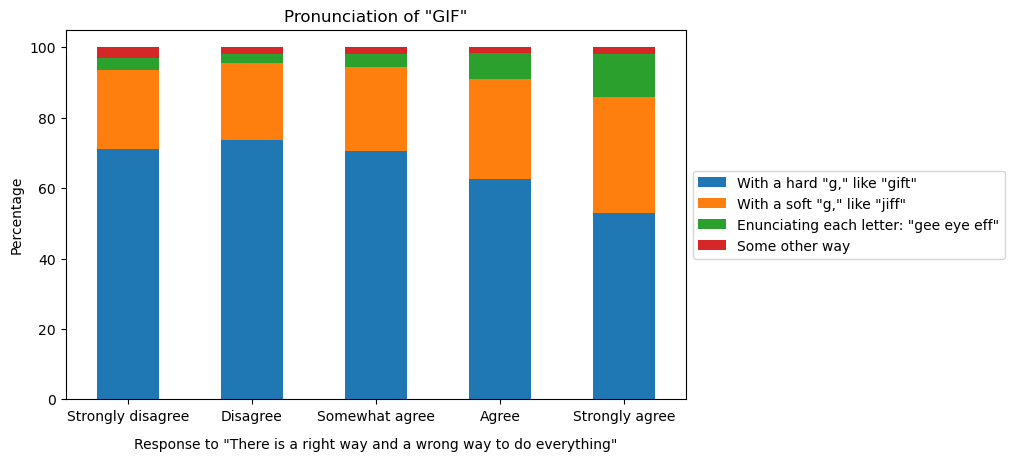

In [11]:
ax = crosstab_df.plot(kind='bar', 
                    stacked=True,  
                    figsize=(10, 6))
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height * 0.8])

# Put a legend to the right of the current axis
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.xlabel('Response to "There is a right way and a wrong way to do everything"', labelpad = 10.0)
plt.xticks(rotation = 0)
ax.invert_xaxis()
plt.ylabel("Percentage")
plt.title('Pronunciation of "GIF"')
plt.show()

The consistency of response appears to drop in line with how much the respondent agrees that there is a right way and a wrong way to do everything.  Those who "Strongly disagree" and "Disagree" produce quite similar results, whereas the more the respondents agree with the "right and wrong way" question, the more diverse their pronunciation answers become.

This seems to suggest that while the respondents agree there is a right and wrong way to do everything, they cannot agree on what the "right" way is.  Perhaps this is because they give the question more thought as they work out what the right answer is, or perhaps they determined an answer in the past and are unwilling to change as their answer must be the "right" one.